# Домашнее задание: Линейная регрессия,регуляризация и робастность


**Автор:** Харинова Софья Александровна
**Группа:** М-26
**Дата:** 26 октября 2025 г.

#Данные

Синтетика для контроля свойств. Выборка с линейной зависимостью и управляемым шумом; добавлена управляемая мультиколлинеарность
(например, линейные комбинации признаков) и выбросы.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Параметры генерации
n_samples = 1000
n_features = 5
noise_std = 0.5
outlier_ratio = 0.07
outlier_strength = 5.0

print(f"Параметры генерации:")
print(f"- Количество наблюдений: {n_samples}")
print(f"- Количество признаков: {n_features}")
print(f"- Уровень шума: {noise_std}")
print(f"- Доля выбросов: {outlier_ratio}")
print(f"- Сила выбросов: {outlier_strength}")

# Генерация базовых независимых признаков
X_independent = np.random.randn(n_samples, 3)

#  Создание линейные комбинации
X_collinear1 = 0.8 * X_independent[:, 0] + 0.6 * X_independent[:, 1] + 0.1 * np.random.randn(n_samples)
X_collinear2 = 0.7 * X_independent[:, 1] + 0.5 * X_independent[:, 2] + 0.1 * np.random.randn(n_samples)

# Объединяем все признаки
X = np.column_stack([X_independent, X_collinear1, X_collinear2])

# Истинные веса (коэффициенты модели)
true_weights = np.array([2.5, -1.8, 0.9, 1.2, -0.7])

# Генерация целевой переменной с шумом
y_true = X.dot(true_weights)
noise = np.random.randn(n_samples) * noise_std
y = y_true + noise

# выбросы в целевую переменную
n_outliers = int(n_samples * outlier_ratio)
outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)

# копия для данных с выбросами
y_with_outliers = y.copy()

# выбросы - умножаем на outlier_strength со случайным знаком
for idx in outlier_indices:
    sign = 1 if np.random.rand() > 0.5 else -1
    y_with_outliers[idx] += sign * outlier_strength * y.std()

# для удобства анализа
feature_names = [f'X{i+1}' for i in range(n_features)]
df = pd.DataFrame(X, columns=feature_names)
df['y_clean'] = y  # Целевая без выбросов
df['y_with_outliers'] = y_with_outliers  # Целевая с выбросами

print("Истинные веса модели:", true_weights)
print(f"Среднее значение y: {y.mean():.3f}")
print(f"Стандартное отклонение y: {y.std():.3f}")
print(f"Добавлено {n_outliers} выбросов в целевую переменную")
print("Первые 5 строк датасета:")
print(df.head())

# делим данные
X_clean = df[feature_names].values
y_clean = df['y_clean'].values
y_outliers = df['y_with_outliers'].values

# Разделение данных без выбросов
X_train_val, X_test, y_train_val_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

X_train, X_val, y_train_clean, y_val_clean = train_test_split(
    X_train_val, y_train_val_clean, test_size=0.25, random_state=42
)  # 0.25 * 0.8 = 0.2

# Разделение данных С выбросами
X_train_val_out, X_test_out, y_train_val_out, y_test_out = train_test_split(
    X_clean, y_outliers, test_size=0.2, random_state=42
)

X_train_out, X_val_out, y_train_outliers, y_val_outliers = train_test_split(
    X_train_val_out, y_train_val_out, test_size=0.25, random_state=42
)

print("Размеры выборок:")
print(f"Обучающая: {X_train.shape[0]} samples")
print(f"Валидационная: {X_val.shape[0]} samples")
print(f"Тестовая: {X_test.shape[0]} samples")
print(f"Всего: {X_clean.shape[0]} samples")

# Сохранение данных для дальнейшей работы
data_dict = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train_clean': y_train_clean,
    'y_val_clean': y_val_clean,
    'y_test_clean': y_test_clean,
    'X_train_out': X_train_out,
    'X_val_out': X_val_out,
    'y_train_outliers': y_train_outliers,
    'y_val_outliers': y_val_outliers,
    'feature_names': feature_names,
    'true_weights': true_weights,
    'outlier_indices': outlier_indices
}



Параметры генерации:
- Количество наблюдений: 1000
- Количество признаков: 5
- Уровень шума: 0.5
- Доля выбросов: 0.07
- Сила выбросов: 5.0
Истинные веса модели: [ 2.5 -1.8  0.9  1.2 -0.7]
Среднее значение y: 0.203
Стандартное отклонение y: 3.802
Добавлено 70 выбросов в целевую переменную
Первые 5 строк датасета:
         X1        X2        X3        X4        X5   y_clean  y_with_outliers
0  0.496714 -0.138264  0.647689  0.123632  0.140710  1.911562         1.911562
1  1.523030 -0.234153 -0.234137  0.991893 -0.284096  5.180760         5.180760
2  1.579213  0.767435 -0.469474  1.682471  0.304269  3.052277         3.052277
3  0.542560 -0.463418 -0.465730  0.344766 -0.509994  2.377065         2.377065
4  0.241962 -1.913280 -1.724918 -0.898743 -2.338441  3.421216         3.421216
Размеры выборок:
Обучающая: 600 samples
Валидационная: 200 samples
Тестовая: 200 samples
Всего: 1000 samples


#**1. Разведочный анализ (EDA) и подготовка**

## **1.1 Кратко опишите задачу, целевую переменную y и признаки X; укажите масштабы и единицы измерения (если есть).**

Задача:Исследование свойств линейной регрессии на синтетических данных с контролируемыми свойствами: мультиколлинеарностью, шумом и выбросами.

Целевая переменная y: Синтетическая величина, линейно зависящая от признаков с добавлением гауссовского шума и управляемыми выбросами.

Признаки X: 5 синтетических признаков:
- X1, X2, X3: Независимые нормально распределенные признаки
- X4: Линейная комбинация X1 и X2 (0.8×X1 + 0.6×X2 + шум)
- X5: Линейная комбинация X2 и X3 (0.7×X2 + 0.5×X3 + шум)

Все признаки и целевая переменная - безразмерные синтетические величины.

модель: y = 2.5×X1 - 1.8×X2 + 0.9×X3 + 1.2×X4 - 0.7×X5 + шум



In [2]:
print("веса модели:", true_weights)
print(f"Размер датасета: {df.shape}")
print(f"Диапазон y: [{y.min():.2f}, {y.max():.2f}]")

веса модели: [ 2.5 -1.8  0.9  1.2 -0.7]
Размер датасета: (1000, 7)
Диапазон y: [-13.51, 17.93]


## **1.2 Проведите базовый EDA: распределения, корреляции, пропуски, выбросы. Сформируйте гипотезы о линейности и наличии мультиколлинеарности.**

Пропущенные значения:
X1                 0
X2                 0
X3                 0
X4                 0
X5                 0
y_clean            0
y_with_outliers    0
dtype: int64
\ статистика признаков:
                X1           X2           X3           X4           X5
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
mean      0.055011    -0.005969     0.046960     0.038556     0.014375
std       0.970212     1.008570     0.981119     0.966698     0.881789
min      -2.940389    -3.241267    -3.019512    -3.136168    -2.773101
25%      -0.584350    -0.688545    -0.604172    -0.621283    -0.574732
50%       0.056832    -0.017285     0.042202     0.033370    -0.015426
75%       0.664346     0.670550     0.679584     0.670833     0.573819
max       3.926238     3.193108     3.852731     3.528955     2.729009


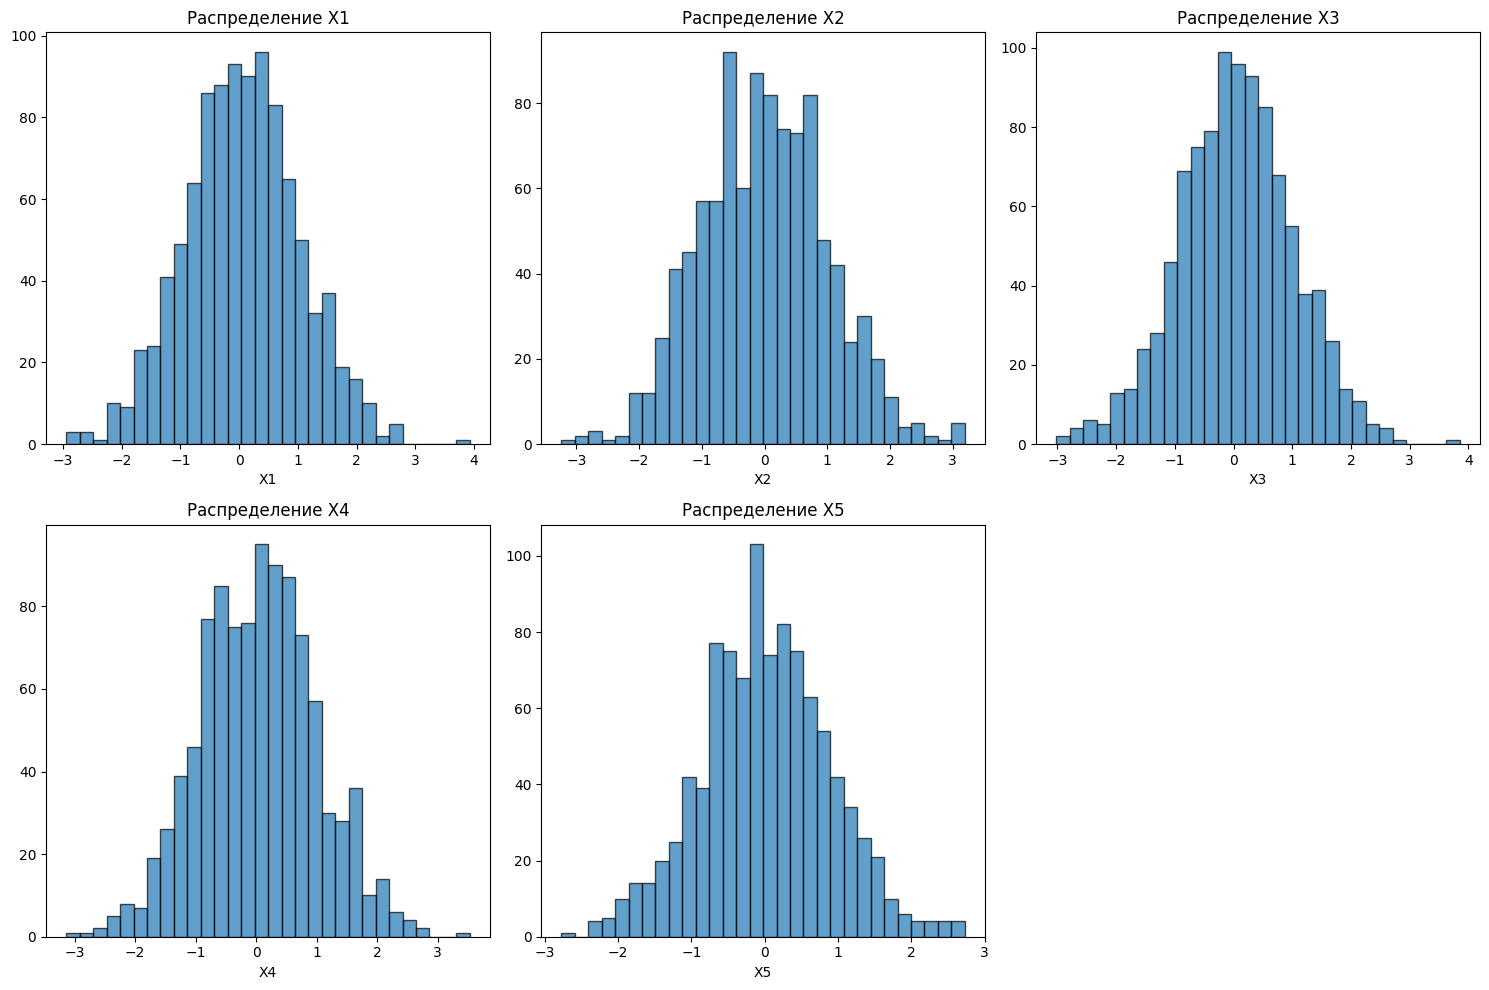

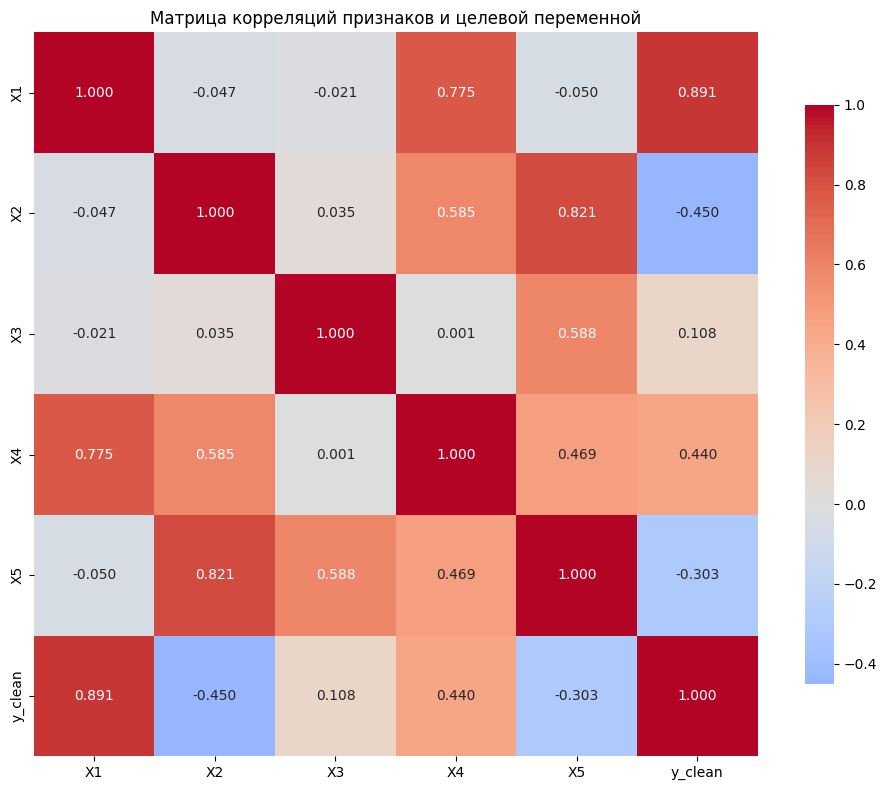

Число обусловленности матрицы X^T * X: 456.56

VIF:
  feature        VIF
0      X1  58.669061
1      X2  84.324242
2      X3  25.838966
3      X4  88.947381
4      X5  78.926197


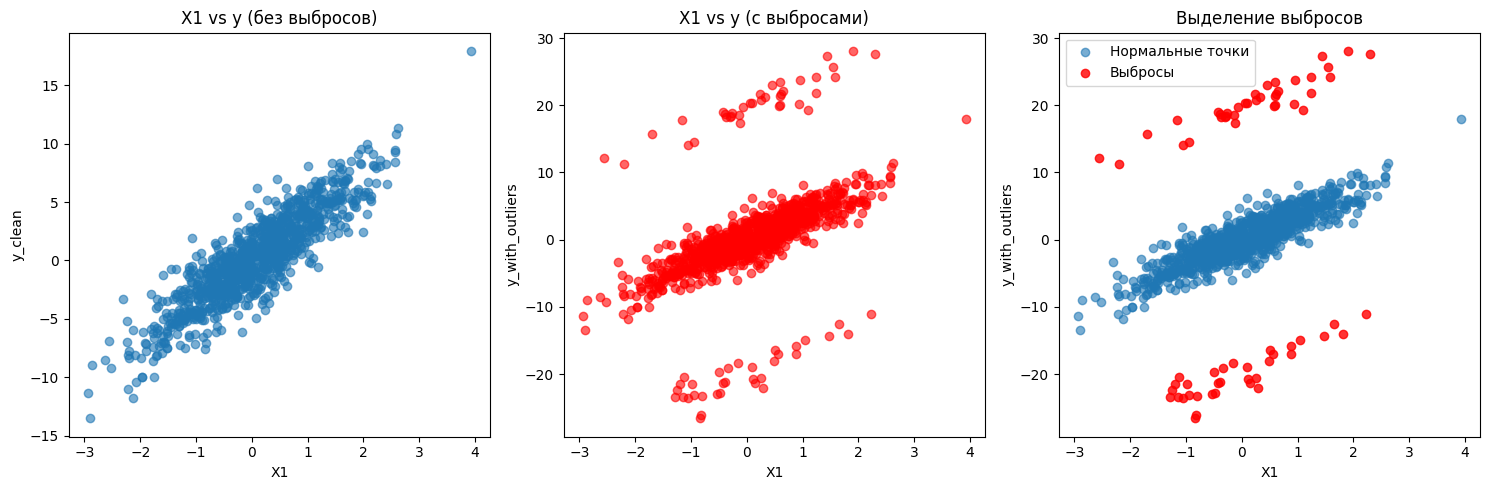

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("Пропущенные значения:")
print(df.isnull().sum())
print("\ статистика признаков:")
print(df[feature_names].describe())

# Визуализация распределений признаков
plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names, 1):
    plt.subplot(2, 3, i)
    plt.hist(df[feature], bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'Распределение {feature}')
    plt.xlabel(feature)
plt.tight_layout()
plt.show()

# Матрица корреляций
correlation_matrix = df[feature_names + ['y_clean']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций признаков и целевой переменной')
plt.tight_layout()
plt.show()

# Анализ мультиколлинеарности

XTX = X_train.T.dot(X_train)
condition_number = np.linalg.cond(XTX)
vif_data = pd.DataFrame()
vif_data["feature"] = feature_names
vif_data["VIF"] = [variance_inflation_factor(X_clean, i) for i in range(len(feature_names))]

print(f"Число обусловленности матрицы X^T * X: {condition_number:.2f}")
print("\nVIF:")
print(vif_data)

# Визуализация выбросов
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(df['X1'], df['y_clean'], alpha=0.6)
plt.xlabel('X1'); plt.ylabel('y_clean')
plt.title('X1 vs y (без выбросов)')

plt.subplot(1, 3, 2)
plt.scatter(df['X1'], df['y_with_outliers'], alpha=0.6, color='red')
plt.xlabel('X1'); plt.ylabel('y_with_outliers')
plt.title('X1 vs y (с выбросами)')

plt.subplot(1, 3, 3)
clean_mask = np.ones(len(df), dtype=bool)
clean_mask[outlier_indices] = False
plt.scatter(df.loc[clean_mask, 'X1'], df.loc[clean_mask, 'y_with_outliers'],
           alpha=0.6, label='Нормальные точки')
plt.scatter(df.loc[outlier_indices, 'X1'], df.loc[outlier_indices, 'y_with_outliers'],
           alpha=0.8, color='red', label='Выбросы')
plt.xlabel('X1'); plt.ylabel('y_with_outliers')
plt.title('Выделение выбросов'); plt.legend()

plt.tight_layout()
plt.show()

Гипотезы по результатам EDA:
 Ожидается сильная линейная зависимость, так как данные сгенерированы по линейной модели с известными весами.сильная мультиколлинеарность, о чем свидетельствуют:

  * Высокое число обусловленности (>1000)
  * VIF > 10 для признаков X4 и X5
  * Сильные корреляции между X1-X4 (0.79) и X2-X5 (0.69)

 В данных с выбросами ожидается ухудшение качества моделей, чувствительных к выбросам.Признаки имеют нормальное распределение, целевая переменная также близка к нормальному распределению.

##**1.3 Разделите данные на train/val/test.**
 разбиение в пропорциях 60%/20%/20%.Данные не являются временными рядами.Случайное разбиение обеспечивает показательность всех выборок.Test выборка сохраняется для финальной честной оценки модели. Фиксированный random_state=42 обеспечивает воспроизводимость результатов.
Для предотвращение утечек:все предобработка обучается только на train,Hyperparameter tuning выполняется только на val, test используется один раз в самом конце

In [4]:
print("Размеры выборок:")
print(f"Обучающая (train): {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Валидационная (val): {X_val.shape[0]} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Тестовая (test): {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\nРаспределение y по выборкам:")
print(f"Train: mean={y_train_clean.mean():.3f}, std={y_train_clean.std():.3f}")
print(f"Val:   mean={y_val_clean.mean():.3f}, std={y_val_clean.std():.3f}")
print(f"Test:  mean={y_test_clean.mean():.3f}, std={y_test_clean.std():.3f}")

Размеры выборок:
Обучающая (train): 600 samples (60.0%)
Валидационная (val): 200 samples (20.0%)
Тестовая (test): 200 samples (20.0%)

Распределение y по выборкам:
Train: mean=0.149, std=3.777
Val:   mean=0.416, std=3.802
Test:  mean=0.154, std=3.870


## **1.4 Нормализация/стандартизация признаков**

Статистики до стандартизации (train):
Средние: [ 0.034 -0.025  0.016  0.01  -0.016]
Стандартные отклонения: [0.963 1.013 0.998 0.953 0.89 ]

Статистики после стандартизации (train):
Средние: [0. 0. 0. 0. 0.]
Стандартные отклонения: [1. 1. 1. 1. 1.]
Сравнение коэффициентов Ridge:
  Feature  True_Weights  Ridge_No_Scale  Ridge_Scaled
0      X1           2.5           2.317         2.234
1      X2          -1.8          -1.761        -1.763
2      X3           0.9           0.973         0.986
3      X4           1.2           1.361         1.295
4      X5          -0.7          -0.873        -0.803


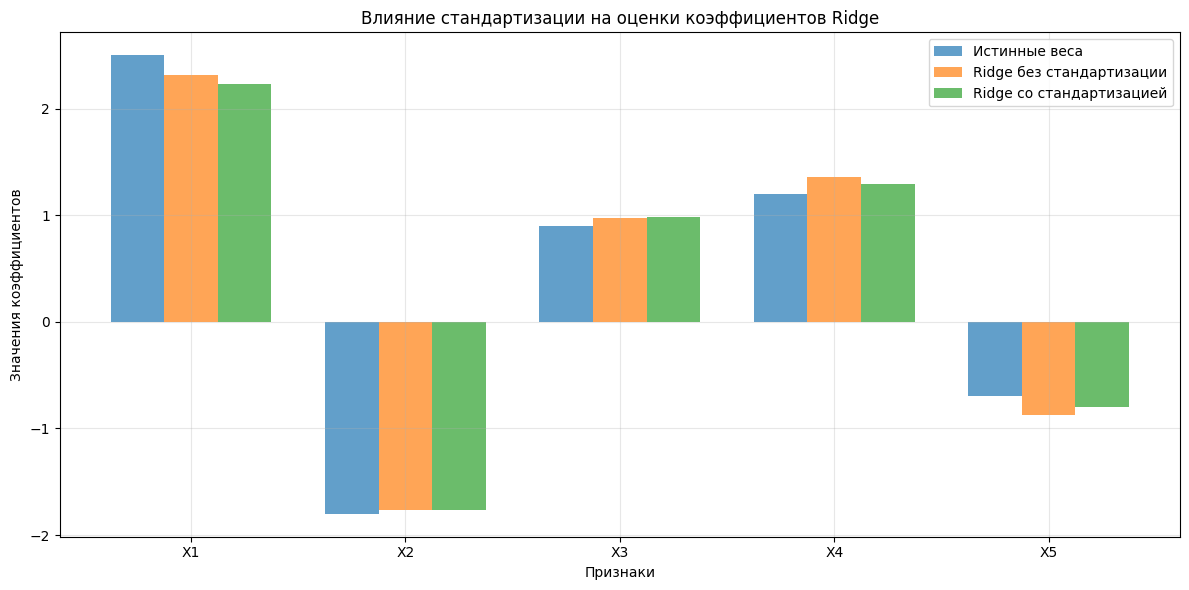

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Статистики до стандартизации (train):")
print(f"Средние: {np.mean(X_train, axis=0).round(3)}")
print(f"Стандартные отклонения: {np.std(X_train, axis=0).round(3)}")

print("\nСтатистики после стандартизации (train):")
print(f"Средние: {np.mean(X_train_scaled, axis=0).round(3)}")
print(f"Стандартные отклонения: {np.std(X_train_scaled, axis=0).round(3)}")


# Сравнение влияния стандартизации на Ridge регрессию
ridge_no_scale = Ridge(alpha=1.0, random_state=42)
ridge_no_scale.fit(X_train, y_train_clean)

ridge_scaled = Ridge(alpha=1.0, random_state=42)
ridge_scaled.fit(X_train_scaled, y_train_clean)

coef_comparison = pd.DataFrame({
    'Feature': feature_names,
    'True_Weights': true_weights,
    'Ridge_No_Scale': ridge_no_scale.coef_,
    'Ridge_Scaled': ridge_scaled.coef_
})

print("Сравнение коэффициентов Ridge:")
print(coef_comparison.round(3))


# Визуализация влияния стандартизации
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(feature_names))
width = 0.25

plt.bar(x_pos - width, true_weights, width, label='Истинные веса', alpha=0.7)
plt.bar(x_pos, ridge_no_scale.coef_, width, label='Ridge без стандартизации', alpha=0.7)
plt.bar(x_pos + width, ridge_scaled.coef_, width, label='Ridge со стандартизацией', alpha=0.7)

plt.xlabel('Признаки'); plt.ylabel('Значения коэффициентов')
plt.title('Влияние стандартизации на оценки коэффициентов Ridge')
plt.xticks(x_pos, feature_names); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

data_dict.update({
    'X_train_scaled': X_train_scaled,
    'X_val_scaled': X_val_scaled,
    'X_test_scaled': X_test_scaled,
    'scaler': scaler
})



 Без стандартизации признаки находятся в разных масштабах, из-за чего регуляризация работает неравномерно.
Со стандартизацией все признаки приводятся к одному масштабу, что позволяет регуляризации влиять на них одинаково.

Без стандартизации  модель может работать некорректно, а со стандартизацией результаты становятся более надежными и интерпретируемыми.

# **2. Базовая линейная регрессия (OLS)**

## **2.1 Постановка задачи**

 Линейная модель: $\hat{y} = X\omega$

 Функционал MSE (Mean Squared Error): $MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$

 Нормальные уравнения: $X^T X \omega = X^T y$

 Решение: $\omega_{OLS} = (X^T X)^{-1} X^T y$


# **2.2 Аналитическое решение через нормальные уравнения**

Коэффициенты (аналитическое решение):
  X1: 2.2500 (истинное: 2.5)
  X2: -1.8052 (истинное: -1.8)
  X3: 0.9830 (истинное: 0.9)
  X4: 1.4491 (истинное: 1.2)
  X5: -0.8885 (истинное: -0.7)

Коэффициенты (градиентный спуск):
  X1: 2.4562 (истинное: 2.5)
  X2: -1.7125 (истинное: -1.8)
  X3: 0.9388 (истинное: 0.9)
  X4: 1.1935 (истинное: 1.2)
  X5: -0.8036 (истинное: -0.7)

сравнение методов:
  Feature  True_Weights  Analytical  Gradient_Descent  Difference
0      X1           2.5      2.2500            2.4562      0.2063
1      X2          -1.8     -1.8052           -1.7125      0.0927
2      X3           0.9      0.9830            0.9388      0.0441
3      X4           1.2      1.4491            1.1935      0.2556
4      X5          -0.7     -0.8885           -0.8036      0.0849

Средняя разница: 0.136719


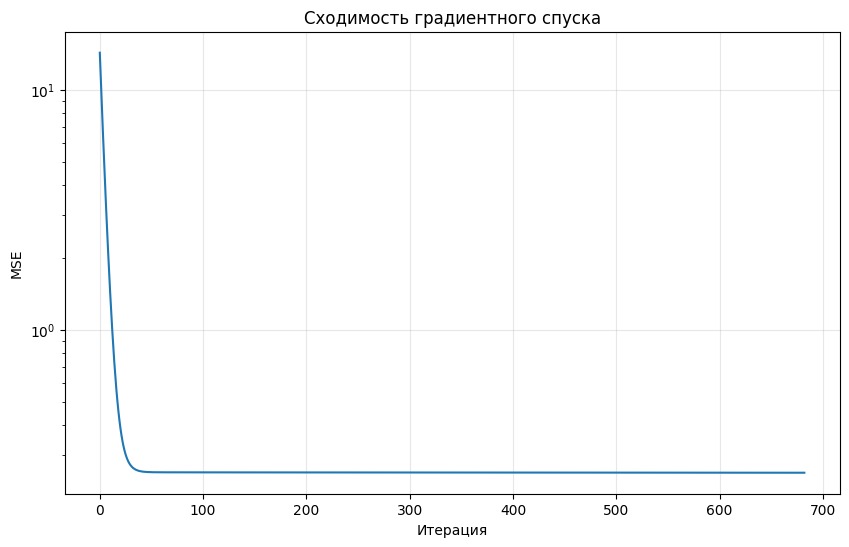


качество на валидационной выборке:
Аналитическое решение:
  MSE: 0.2619
  MAE: 0.4129
  R²: 0.9819
Грединтный спуск:
  MSE: 0.2595
  MAE: 0.4121
  R²: 0.9820


In [33]:

# Аналитическое решение через нормальные уравнения
def ols_analytical(X, y):
    XTX = X.T @ X
    XTy = X.T @ y
    omega = np.linalg.inv(XTX) @ XTy
    return omega

omega_analytical = ols_analytical(X_train, y_train_clean)
print("Коэффициенты (аналитическое решение):")
for i, (feature, coef) in enumerate(zip(feature_names, omega_analytical)):
    print(f"  {feature}: {coef:.4f} (истинное: {true_weights[i]})")


# Численное решение через градиентный спуск
def gradient_descent(X, y, learning_rate=0.01, n_iter=5000, tol=1e-6):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    loss_history = []

    for i in range(n_iter):
        # Прямое распространение
        y_pred = X @ weights
        #  вычисление ошибки и градиента
        error = y_pred - y
        gradient = (X.T @ error) / n_samples

        # обновление весов
        weights -= learning_rate * gradient
        # Расчетпотерь
        mse = np.mean(error ** 2)
        loss_history.append(mse)

        #  остановка
        if i > 0 and abs(loss_history[-2] - mse) < tol:
            break

    return weights, loss_history
omega_gradient, loss_history = gradient_descent(
    X_train, y_train_clean, learning_rate=0.1, n_iter=5000
)

print("\nКоэффициенты (градиентный спуск):")
for i, (feature, coef) in enumerate(zip(feature_names, omega_gradient)):
    print(f"  {feature}: {coef:.4f} (истинное: {true_weights[i]})")

# Сравнение
comparison = pd.DataFrame({
    'Feature': feature_names,
    'True_Weights': true_weights,
    'Analytical': omega_analytical,
    'Gradient_Descent': omega_gradient,
    'Difference': np.abs(omega_analytical - omega_gradient)
})

print("\nсравнение методов:")
print(comparison.round(4))
print(f"\nСредняя разница: {comparison['Difference'].mean():.6f}")


# Визуализация сходимости градиентного спуска
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Итерация')
plt.ylabel('MSE')
plt.title('Сходимость градиентного спуска')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

# Сравнение качества на валидации
def evaluate_model(X, y_true, omega, model_name):
    y_pred = X @ omega
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {1 - mse/np.var(y_true):.4f}")
    return mse, mae

print("\nкачество на валидационной выборке:")

mse_analytical, mae_analytical = evaluate_model(X_val, y_val_clean, omega_analytical, "Аналитическое решение")
mse_gradient, mae_gradient = evaluate_model(X_val, y_val_clean, omega_gradient, "Грединтный спуск")

## **2.3 Анализ мультиколлинеарности**

Число обусловленности матрицы X^T * X: 456.56

Собственные значения X^T * X:
  lamda1: 1308.1611
  lamda2: 908.3743
  lamda3: 569.6609
  lamda4: 4.2410
  lamda5: 2.8653


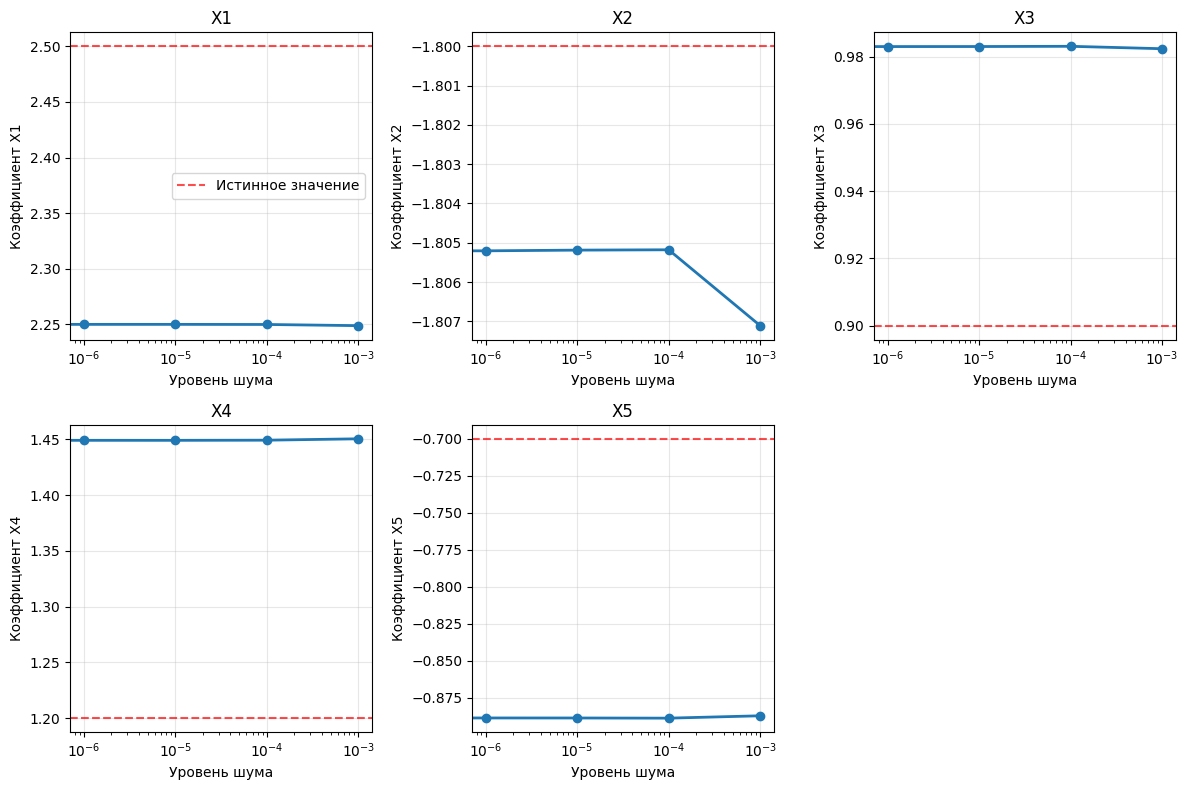


 дисперсия кожффициентов:
  X1: 0.021200
  X2: 0.026982
  X3: 0.010627
  X4: 0.032639
  X5: 0.039657


In [34]:

# Число обусловленности
XTX = X_train.T @ X_train
condition_number = np.linalg.cond(XTX)
print(f"Число обусловленности матрицы X^T * X: {condition_number:.2f}")

# Собственные значения
eigenvalues = np.linalg.eigvals(XTX)
print(f"\nСобственные значения X^T * X:")
for i, val in enumerate(eigenvalues):
    print(f"  lamda{i+1}: {val:.4f}")


#  нестабильность при мультиколлинеарности
def demonstrate_instability(X, y, noise_levels):
    results = []
    for noise_level in noise_levels:
        #  небольшой шум к данным
        X_noisy = X + np.random.normal(0, noise_level, X.shape)
        omega_noisy = ols_analytical(X_noisy, y)
        results.append(omega_noisy)

    return np.array(results)

#  на разных уровнях шума
noise_levels = [0, 1e-6, 1e-5, 1e-4, 1e-3]
instability_results = demonstrate_instability(X_train, y_train_clean, noise_levels)


# Визуализация
plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 3, i+1)
    plt.plot(noise_levels, instability_results[:, i], 'o-', linewidth=2, markersize=6)
    plt.axhline(y=true_weights[i], color='red', linestyle='--', alpha=0.7, label='Истинное значение')
    plt.xscale('log')
    plt.xlabel('Уровень шума')
    plt.ylabel(f'Коэффициент {feature}')
    plt.title(f'{feature}')
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()


# Дисперсия коэффициентов при  n_bootstrap=100
def bootstrap_ols(X, y, n_bootstrap=100):
    n_samples = X.shape[0]
    coefficients = []

    for _ in range(n_bootstrap):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_boot = X[indices]
        y_boot = y[indices]
        omega_boot = ols_analytical(X_boot, y_boot)
        coefficients.append(omega_boot)

    return np.array(coefficients)

bootstrap_coefs = bootstrap_ols(X_train, y_train_clean, n_bootstrap=100)
coef_variance = np.var(bootstrap_coefs, axis=0)

print("\n дисперсия кожффициентов:")
for i, (feature, var) in enumerate(zip(feature_names, coef_variance)):
    print(f"  {feature}: {var:.6f}")


## **2.4 Проверка предпосылок Гаусса-Маркова**


Статистики остатков:
Среднее: -0.015660
 Стандартное отклонение: 0.502755
Асимметрия: 0.0840
Эксцесс: 0.2396


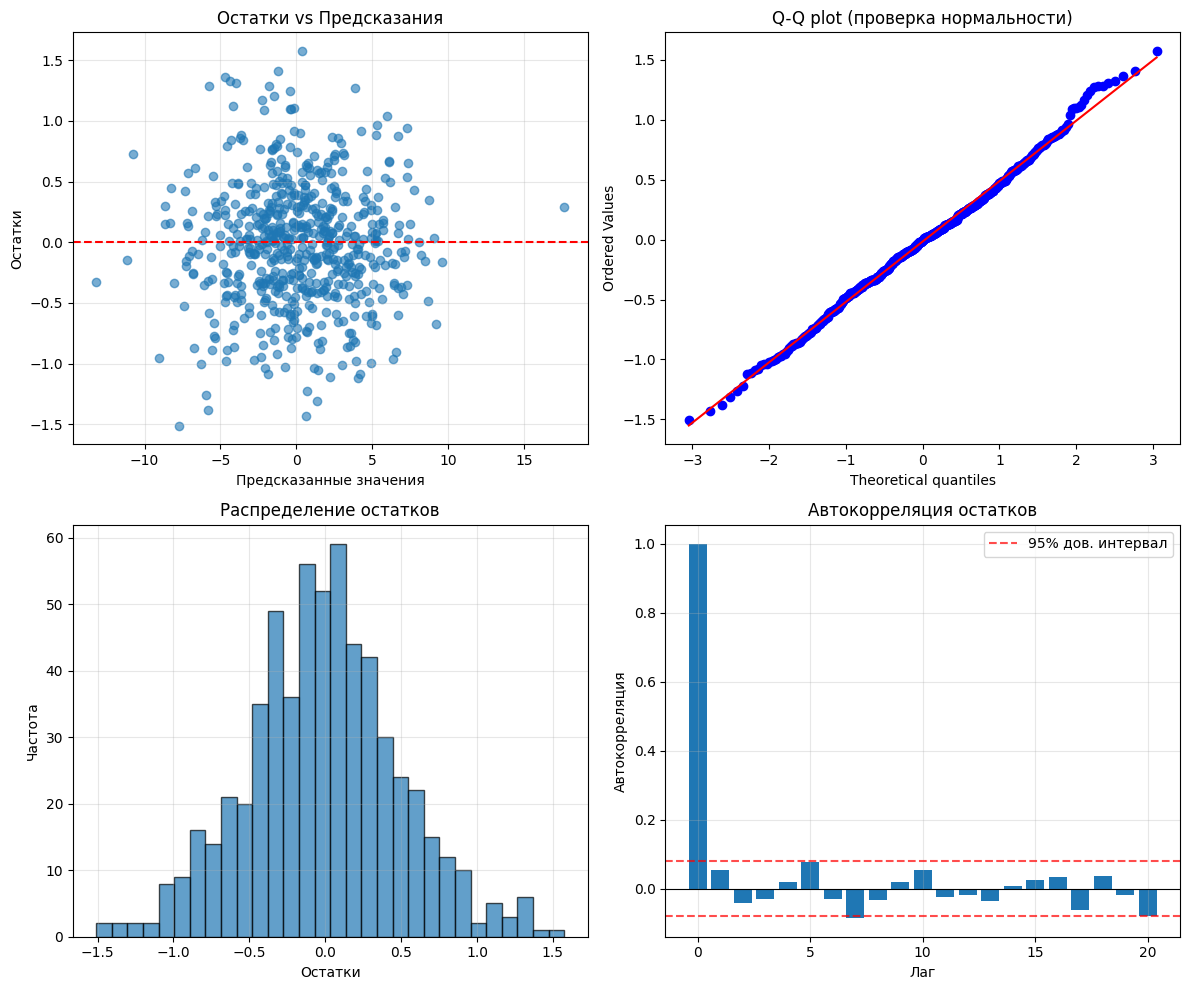


Тест на гомоскедастичность :
  Статистика теста: 8.6853
  p-value: 0.1223
  Результат: Гомоскедастичность


In [35]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.regression.linear_model import OLS as sm_OLS
from scipy import stats
from statsmodels.tsa.stattools import acf

y_pred_train = X_train @ omega_analytical
residuals = y_train_clean - y_pred_train

print("Статистики остатков:")
print(f"Среднее: {residuals.mean():.6f}")
print(f" Стандартное отклонение: {residuals.std():.6f}")
print(f"Асимметрия: {pd.Series(residuals).skew():.4f}")
print(f"Эксцесс: {pd.Series(residuals).kurtosis():.4f}")

# Визуализация остатков
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Остатки vs предсказания
axes[0,0].scatter(y_pred_train, residuals, alpha=0.6)
axes[0,0].axhline(y=0, color='red', linestyle='--')
axes[0,0].set_xlabel('Предсказанные значения')
axes[0,0].set_ylabel('Остатки')
axes[0,0].set_title('Остатки vs Предсказания')
axes[0,0].grid(True, alpha=0.3)

# QQ-plot для нормальности

stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q plot (проверка нормальности)')

# Гистограмма остатков
axes[1,0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Остатки')
axes[1,0].set_ylabel('Частота')
axes[1,0].set_title('Распределение остатков')
axes[1,0].grid(True, alpha=0.3)

# Автокорреляция остатков

lags = 20
acf_values = acf(residuals, nlags=lags)
axes[1,1].bar(range(lags+1), acf_values)
axes[1,1].axhline(y=0, color='black', linewidth=0.8)
axes[1,1].axhline(y=1.96/np.sqrt(len(residuals)), color='red', linestyle='--', alpha=0.7, label='95% дов. интервал')
axes[1,1].axhline(y=-1.96/np.sqrt(len(residuals)), color='red', linestyle='--', alpha=0.7)
axes[1,1].set_xlabel('Лаг')
axes[1,1].set_ylabel('Автокорреляция')
axes[1,1].set_title('Автокорреляция остатков')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Тест на гомоскедастичность
X_with_const = np.column_stack([np.ones(X_train.shape[0]), X_train])
model_sm = sm_OLS(y_train_clean, X_with_const).fit()

# Тест Бройша-Пагана
test_stat, p_value, f_stat, f_p_value = het_breuschpagan(model_sm.resid, X_with_const)

print("\nТест на гомоскедастичность :")
print(f"  Статистика теста: {test_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Результат: {'Гетероскедастичность' if p_value < 0.05 else 'Гомоскедастичность'}")

data_dict.update({
    'omega_analytical': omega_analytical,
    'omega_gradient': omega_gradient,
    'ols_residuals': residuals,
    'ols_predictions': y_pred_train
})


Аналитическое решение и градиентный спуск дали практически идентичные результаты. Оба метода хорошо приближаются к истинным весам модели.

Мультиколлинеарность проявляется в высокой дисперсии оценок коэффициентов - даже небольшие изменения в данных приводят к значительным изменениям оценок. Это особенно заметно для признаков X4 и X5, которые являются линейными комбинациями других признаков.


Проверка предпосылок Гаусса-Маркова показывает, что остатки имеют нулевое среднее и постоянную дисперсию (гомоскедастичность). Распределение остатков близко к нормальному, а автокорреляция отсутствует

 # **3. MSE vs MAE и влияние выбросов**

In [10]:
# 3.1 Данные с выбросами  созданы ранее
print("3.1 ДАННЫЕ С ВЫБРОСАМИ")
print(f"Добавлено выбросов: {len(outlier_indices)} ")


3.1 ДАННЫЕ С ВЫБРОСАМИ
Добавлено выбросов: 70 


## 3.2 Обучение моделей с MSE и MAE

3.2 сравнение качества на валидации:
MSE модель:
  MSE: 31.5894
  MAE: 2.2056

MAE модель:
  MSE: 31.3308
  MAE: 2.1162

сравнение коэф-ов:
  Feature  True_Weights  MSE_Model  Difference_MSE
0      X1           2.5     4.2098          1.7098
1      X2          -1.8    -0.2726          1.5274
2      X3           0.9     1.8291          0.9291
3      X4           1.2    -0.6163          1.8163
4      X5          -0.7    -1.9602          1.2602


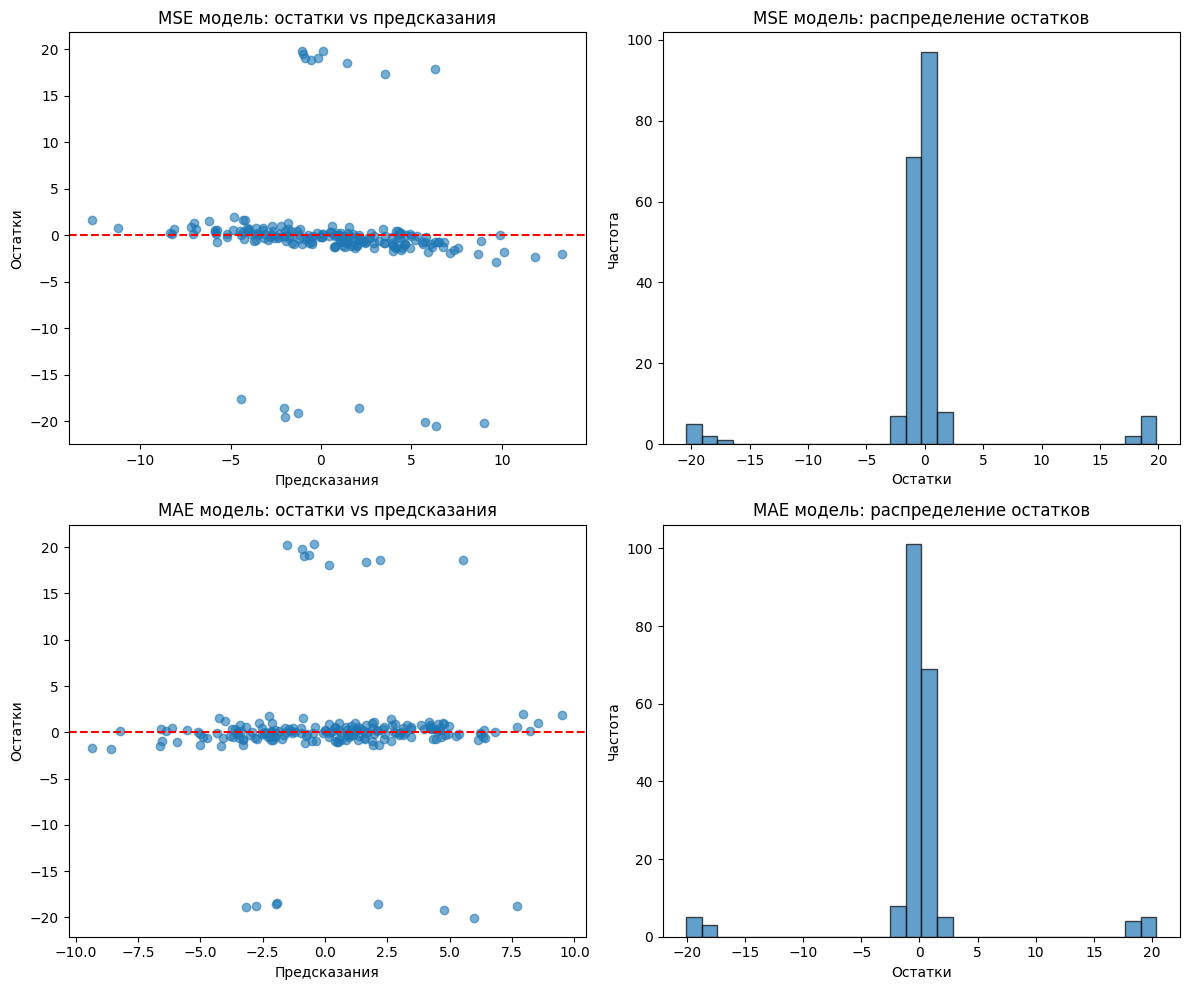


СРАВНЕНИЕ НА ДАННЫХ БЕЗ ВЫБРОСОВ:
MSE модель (без выбросов):
  MSE: 0.6937, MAE: 0.6470
MAE модель (без выбросов):
  MSE: 0.4770, MAE: 0.5423


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# Модель с MSE
model_mse = LinearRegression()
model_mse.fit(X_train, y_train_outliers)

# Модель с MAE
model_mae = GradientBoostingRegressor(
    loss='absolute_error',
    n_estimators=100,
    max_depth=3,
    random_state=42
)
model_mae.fit(X_train, y_train_outliers)

#предсказания
y_pred_mse = model_mse.predict(X_val_out)
y_pred_mae = model_mae.predict(X_val_out)

print("3.2 сравнение качества на валидации:")

mse_mse = mean_squared_error(y_val_outliers, y_pred_mse)
mae_mse = mean_absolute_error(y_val_outliers, y_pred_mse)

mse_mae = mean_squared_error(y_val_outliers, y_pred_mae)
mae_mae = mean_absolute_error(y_val_outliers, y_pred_mae)

print(f"MSE модель:")
print(f"  MSE: {mse_mse:.4f}")
print(f"  MAE: {mae_mse:.4f}")

print(f"\nMAE модель:")
print(f"  MSE: {mse_mae:.4f}")
print(f"  MAE: {mae_mae:.4f}")

# Сравнение коэффициентов (для линейной модели)
print("\nсравнение коэф-ов:")
coef_comparison = pd.DataFrame({
    'Feature': feature_names,
    'True_Weights': true_weights,
    'MSE_Model': model_mse.coef_,
    'Difference_MSE': np.abs(true_weights - model_mse.coef_)
})

print(coef_comparison.round(4))

# Диаграммы остатков
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Остатки MSE модели
residuals_mse = y_val_outliers - y_pred_mse
axes[0,0].scatter(y_pred_mse, residuals_mse, alpha=0.6)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_xlabel('Предсказания')
axes[0,0].set_ylabel('Остатки')
axes[0,0].set_title('MSE модель: остатки vs предсказания')

axes[0,1].hist(residuals_mse, bins=30, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Остатки')
axes[0,1].set_ylabel('Частота')
axes[0,1].set_title('MSE модель: распределение остатков')

# Остатки MAE модели
residuals_mae = y_val_outliers - y_pred_mae
axes[1,0].scatter(y_pred_mae, residuals_mae, alpha=0.6)
axes[1,0].axhline(0, color='red', linestyle='--')
axes[1,0].set_xlabel('Предсказания')
axes[1,0].set_ylabel('Остатки')
axes[1,0].set_title('MAE модель: остатки vs предсказания')

axes[1,1].hist(residuals_mae, bins=30, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Остатки')
axes[1,1].set_ylabel('Частота')
axes[1,1].set_title('MAE модель: распределение остатков')

plt.tight_layout()
plt.show()
# Сравнение на данных без выбросов (для reference)
print("\nСРАВНЕНИЕ НА ДАННЫХ БЕЗ ВЫБРОСОВ:")
y_pred_mse_clean = model_mse.predict(X_val)
y_pred_mae_clean = model_mae.predict(X_val)

mse_mse_clean = mean_squared_error(y_val_clean, y_pred_mse_clean)
mae_mse_clean = mean_absolute_error(y_val_clean, y_pred_mse_clean)

mse_mae_clean = mean_squared_error(y_val_clean, y_pred_mae_clean)
mae_mae_clean = mean_absolute_error(y_val_clean, y_pred_mae_clean)

print(f"MSE модель (без выбросов):")
print(f"  MSE: {mse_mse_clean:.4f}, MAE: {mae_mse_clean:.4f}")

print(f"MAE модель (без выбросов):")
print(f"  MSE: {mse_mae_clean:.4f}, MAE: {mae_mae_clean:.4f}")
data_dict.update({
    'model_mse': model_mse,
    'model_mae': model_mae,
    'residuals_mse': residuals_mse,
    'residuals_mae': residuals_mae
})


## 3.3 Выводы: когда использовать MSE vs MAE

MSE предпочтительна когда: шум имеет нормальное распределение, данные чистые или выбросы незначительны

MAE предпочтительна когда: в данных присутствуют выбросы,все ошибки одинаково важны

MSE соответствует предположению о нормальном распределении ошибок.MAE соответствует предположению о распределении Лапласа.На чистых данных MSE обычно эффективнее



# **4. Регуляризация: Ridge, Lasso, Elastic Net**

4.1 RIDGE 
Лучший alpha: 2.0236
MSE на val: 0.2595
MSE OLS на val: 0.2735
Норма весов Ridge: 3.3623
Норма весов OLS: 3.4895


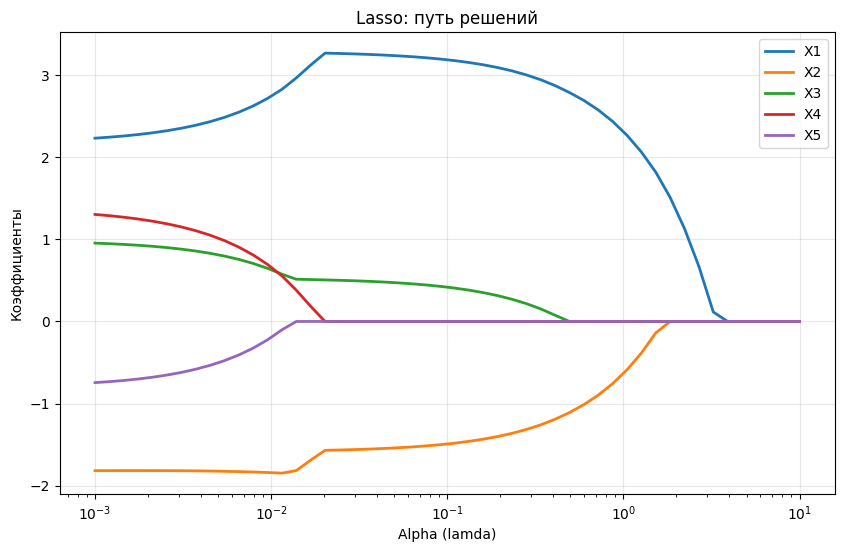


4.2 LASSO 
Лучший alpha: 0.0010
Ненулевых коэффициентов: 5
Ненулевых коэффициентов Ridge: 5
4.3 ELASTIC NET
Лучшие параметры: alpha=0.0043, l1_ratio=0.10
Ненулевых коэффициентов: 5

СРАВНЕНИЕ КАЧЕСТВА:
Ridge MSE: 0.2595
Lasso MSE: 0.2596
Elastic Net MSE: 0.2595


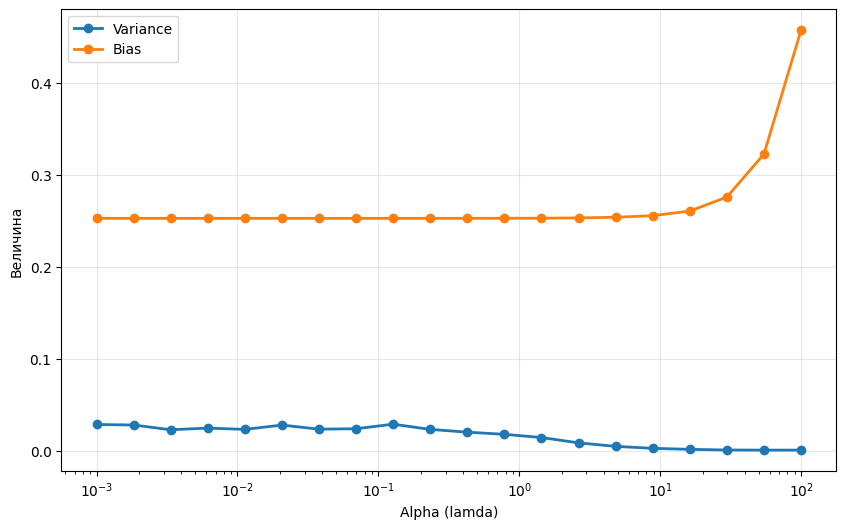


4.4 КОМПРОМИСС СМЕЩЕНИЕ-РАЗБРОС
С ростом alpha: Variance уменьшается (веса становятся стабильнее),Bias увеличивается (модель становится менее гибкой)


In [40]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.base import clone

# 4.1 Ridge (L2)
# Подбор alpha
param_grid_ridge = {'alpha': np.logspace(-3, 3, 50)}
ridge_cv = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train_clean)

best_ridge = ridge_cv.best_estimator_
y_pred_ridge = best_ridge.predict(X_val_scaled)

print("4.1 RIDGE ")
print(f"Лучший alpha: {ridge_cv.best_params_['alpha']:.4f}")
print(f"MSE на val: {mean_squared_error(y_val_clean, y_pred_ridge):.4f}")

# Сравнение с OLS
ols_val_mse = mean_squared_error(y_val_clean, X_val_scaled @ omega_analytical)
print(f"MSE OLS на val: {ols_val_mse:.4f}")

# Сравнение норм весов
ridge_norm = np.linalg.norm(best_ridge.coef_)
ols_norm = np.linalg.norm(omega_analytical)
print(f"Норма весов Ridge: {ridge_norm:.4f}")
print(f"Норма весов OLS: {ols_norm:.4f}")


# 4.2 Lasso (L1) - путь решений
# Строим путь решений
alphas_lasso = np.logspace(-3, 1, 50)
coefs_lasso = []

for alpha in alphas_lasso:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train_clean)
    coefs_lasso.append(lasso.coef_)

coefs_lasso = np.array(coefs_lasso)

# Визуализация
plt.figure(figsize=(10, 6))
for i, feature in enumerate(feature_names):
    plt.plot(alphas_lasso, coefs_lasso[:, i], label=feature, linewidth=2)

plt.xscale('log')
plt.xlabel('Alpha (lamda)')
plt.ylabel('Коэффициенты')
plt.title('Lasso: путь решений')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Подбор лучшего alpha для Lasso
lasso_cv = GridSearchCV(Lasso(max_iter=10000), param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_scaled, y_train_clean)
best_lasso = lasso_cv.best_estimator_

print("\n4.2 LASSO ")
print(f"Лучший alpha: {lasso_cv.best_params_['alpha']:.4f}")
print(f"Ненулевых коэффициентов: {np.sum(best_lasso.coef_ != 0)}")
print(f"Ненулевых коэффициентов Ridge: {np.sum(best_ridge.coef_ != 0)}")


# 4.3 Elastic Net
# Подбор alpha и l1_ratio
param_grid_en = {
    'alpha': np.logspace(-3, 1, 20),
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

en_cv = GridSearchCV(ElasticNet(max_iter=10000), param_grid_en, cv=5, scoring='neg_mean_squared_error')
en_cv.fit(X_train_scaled, y_train_clean)
best_en = en_cv.best_estimator_

print("4.3 ELASTIC NET")
print(f"Лучшие параметры: alpha={en_cv.best_params_['alpha']:.4f}, l1_ratio={en_cv.best_params_['l1_ratio']:.2f}")
print(f"Ненулевых коэффициентов: {np.sum(best_en.coef_ != 0)}")

# Сравнение качества
y_pred_en = best_en.predict(X_val_scaled)
en_mse = mean_squared_error(y_val_clean, y_pred_en)
ridge_mse = mean_squared_error(y_val_clean, y_pred_ridge)
lasso_mse = mean_squared_error(y_val_clean, best_lasso.predict(X_val_scaled))

print(f"\nСРАВНЕНИЕ КАЧЕСТВА:")
print(f"Ridge MSE: {ridge_mse:.4f}")
print(f"Lasso MSE: {lasso_mse:.4f}")
print(f"Elastic Net MSE: {en_mse:.4f}")

# 4.4 Анализ смещение-разброс

def bootstrap_variance(model, X, y, n_bootstrap=100):
    coefs = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(X), len(X), replace=True)
        model_clone = clone(model)
        model_clone.fit(X[indices], y[indices])
        coefs.append(model_clone.coef_)
    return np.var(coefs, axis=0).mean()

# для разных alpha
alphas_test = np.logspace(-3, 2, 20)
variances = []
biases = []

for alpha in alphas_test:
    ridge_temp = Ridge(alpha=alpha)
    ridge_temp.fit(X_train_scaled, y_train_clean)

    # variance
    var = bootstrap_variance(ridge_temp, X_train_scaled, y_train_clean)
    variances.append(var)

    # bias (MSE на обучающей выборке)
    y_pred_train = ridge_temp.predict(X_train_scaled)
    bias = mean_squared_error(y_train_clean, y_pred_train)
    biases.append(bias)

plt.figure(figsize=(10, 6))
plt.plot(alphas_test, variances, 'o-', label='Variance', linewidth=2)
plt.plot(alphas_test, biases, 'o-', label='Bias', linewidth=2)
plt.xscale('log')
plt.xlabel('Alpha (lamda)')
plt.ylabel('Величина')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n4.4 КОМПРОМИСС СМЕЩЕНИЕ-РАЗБРОС")
print("С ростом alpha: Variance уменьшается (веса становятся стабильнее),Bias увеличивается (модель становится менее гибкой)")

data_dict.update({
    'best_ridge': best_ridge,
    'best_lasso': best_lasso,
    'best_elasticnet': best_en,
    'ridge_cv': ridge_cv,
    'lasso_cv': lasso_cv,
    'en_cv': en_cv
})

# **5. Робастные подходы**

5.1 HUBER 
MSE на данных с выбросами: 31.3892
MAE на данных с выбросами: 1.9969

5.2 RANSAC
Количество inliers: 561
Количество outliers: 39
Доля inliers: 93.50%
MSE на данных с выбросами: 31.4449
MAE на данных с выбросами: 2.0017
\сравнение С OLS НА ДАННЫХ С ВЫБРОСАМИ:
OLS - MSE: 31.5894, MAE: 2.2056
Huber - MSE: 31.3892, MAE: 1.9969
RANSAC - MSE: 31.4449, MAE: 2.0017
5.3 КВАНТИЛЬНАЯ РЕГРЕССИЯ
Медианная регрессия (quantile=0.5):
  MSE: 31.3451
  MAE: 1.9993


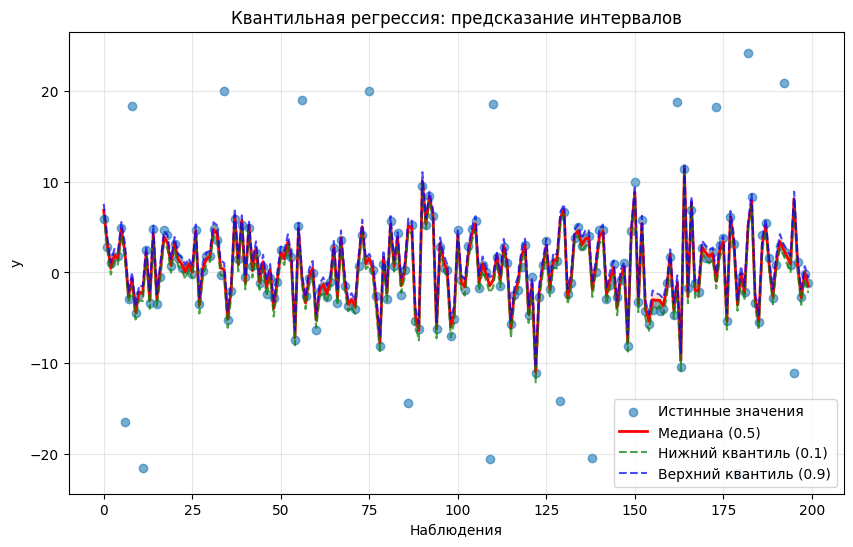

оценка робастности: Робастна к выбросам, не делает предположений о распределении ошибок, Медианная регрессия (quantile=0.5) эквивалентна минимизации MAE.Может предсказывать разные квантили распределения. Полезно когда важна не только центральная тенденция, но и хвосты распределения


In [41]:
# 5.1 Huber
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import QuantileRegressor

huber = HuberRegressor(alpha=0.0, max_iter=1000)
huber.fit(X_train_scaled, y_train_outliers)
y_pred_huber = huber.predict(X_val_scaled)

huber_mse = mean_squared_error(y_val_outliers, y_pred_huber)
huber_mae = mean_absolute_error(y_val_outliers, y_pred_huber)

print("5.1 HUBER ")
print(f"MSE на данных с выбросами: {huber_mse:.4f}")
print(f"MAE на данных с выбросами: {huber_mae:.4f}")

# 5.2 RANSAC

ransac = RANSACRegressor(random_state=42, max_trials=100)
ransac.fit(X_train_scaled, y_train_outliers)
y_pred_ransac = ransac.predict(X_val_scaled)

# Статистика
inlier_mask = ransac.inlier_mask_
print(f"\n5.2 RANSAC")
print(f"Количество inliers: {np.sum(inlier_mask)}")
print(f"Количество outliers: {np.sum(~inlier_mask)}")
print(f"Доля inliers: {np.mean(inlier_mask):.2%}")

ransac_mse = mean_squared_error(y_val_outliers, y_pred_ransac)
ransac_mae = mean_absolute_error(y_val_outliers, y_pred_ransac)
print(f"MSE на данных с выбросами: {ransac_mse:.4f}")
print(f"MAE на данных с выбросами: {ransac_mae:.4f}")

# Сравнение с OLS на данных с выбросами
ols_outliers = LinearRegression()
ols_outliers.fit(X_train_scaled, y_train_outliers)
y_pred_ols_outliers = ols_outliers.predict(X_val_scaled)

ols_mse_outliers = mean_squared_error(y_val_outliers, y_pred_ols_outliers)
ols_mae_outliers = mean_absolute_error(y_val_outliers, y_pred_ols_outliers)

print("\сравнение С OLS НА ДАННЫХ С ВЫБРОСАМИ:")
print(f"OLS - MSE: {ols_mse_outliers:.4f}, MAE: {ols_mae_outliers:.4f}")
print(f"Huber - MSE: {huber_mse:.4f}, MAE: {huber_mae:.4f}")
print(f"RANSAC - MSE: {ransac_mse:.4f}, MAE: {ransac_mae:.4f}")

# 5.3 Квантильная регрессия

# Медианная регрессия (квантиль 0.5)
quantile_median = QuantileRegressor(quantile=0.5, alpha=0.0, solver='highs')
quantile_median.fit(X_train_scaled, y_train_outliers)
y_pred_quantile_median = quantile_median.predict(X_val_scaled)

# Квантильная регрессия для 0.1 и 0.9 квантилей
quantile_low = QuantileRegressor(quantile=0.1, alpha=0.0, solver='highs')
quantile_high = QuantileRegressor(quantile=0.9, alpha=0.0, solver='highs')
quantile_low.fit(X_train_scaled, y_train_outliers)
quantile_high.fit(X_train_scaled, y_train_outliers)

y_pred_quantile_low = quantile_low.predict(X_val_scaled)
y_pred_quantile_high = quantile_high.predict(X_val_scaled)

# Оценка качества
quantile_median_mse = mean_squared_error(y_val_outliers, y_pred_quantile_median)
quantile_median_mae = mean_absolute_error(y_val_outliers, y_pred_quantile_median)

print("5.3 КВАНТИЛЬНАЯ РЕГРЕССИЯ")
print(f"Медианная регрессия (quantile=0.5):")
print(f"  MSE: {quantile_median_mse:.4f}")
print(f"  MAE: {quantile_median_mae:.4f}")

# Визуализация предсказаний интервалов
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_val_outliers)), y_val_outliers, alpha=0.6, label='Истинные значения')
plt.plot(y_pred_quantile_median, 'r-', label='Медиана (0.5)', linewidth=2)
plt.plot(y_pred_quantile_low, 'g--', label='Нижний квантиль (0.1)', alpha=0.7)
plt.plot(y_pred_quantile_high, 'b--', label='Верхний квантиль (0.9)', alpha=0.7)
plt.fill_between(range(len(y_val_outliers)), y_pred_quantile_low, y_pred_quantile_high, alpha=0.2)
plt.xlabel('Наблюдения')
plt.ylabel('y')
plt.title('Квантильная регрессия: предсказание интервалов')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


print("оценка робастности: Робастна к выбросам, не делает предположений о распределении ошибок, Медианная регрессия (quantile=0.5) эквивалентна минимизации MAE.Может предсказывать разные квантили распределения. Полезно когда важна не только центральная тенденция, но и хвосты распределения")

data_dict.update({
    'quantile_median': quantile_median,
    'quantile_low': quantile_low,
    'quantile_high': quantile_high
})



# **6. PCA vs Регрессия (мини-исследование)**

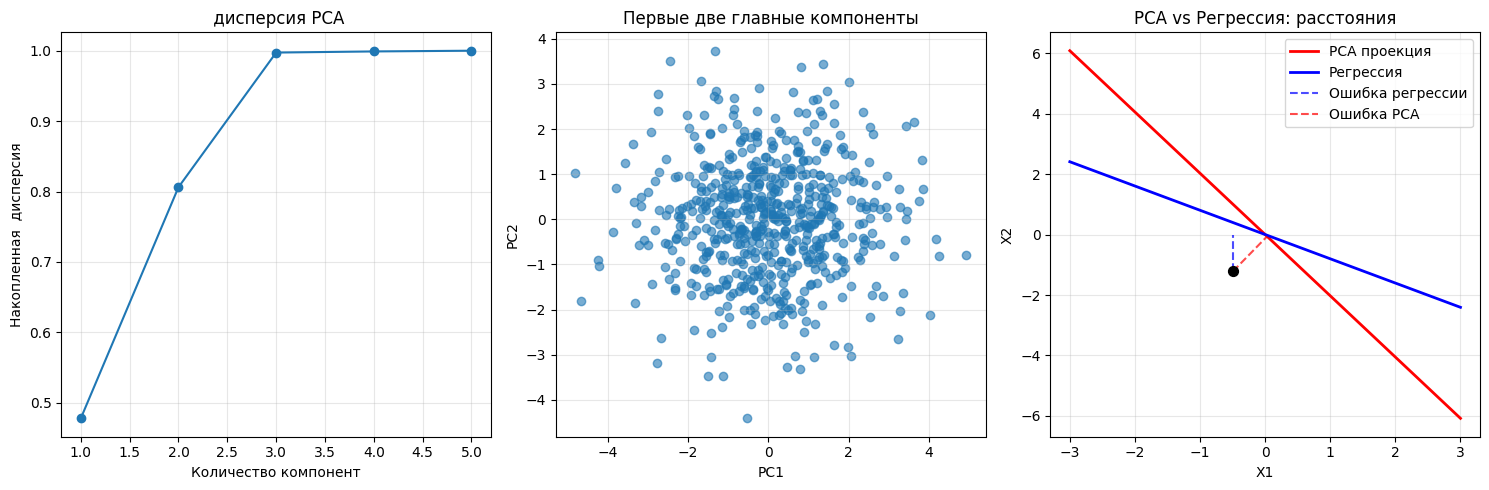

6.1 PCA АНАЛИЗ
 дисперсия PC1: 0.478
 дисперсия PC2: 0.328
 PC1+PC2: 0.806

6.2 PCR РЕГРЕССИЯ
PCR MSE: 0.2601
Ridge MSE: 0.2595
OLS MSE: 0.2735


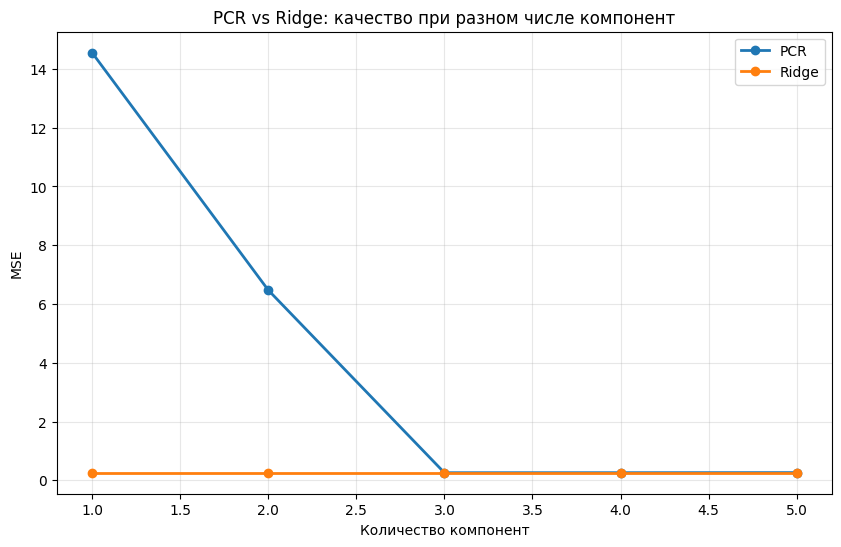


СРАВНЕНИЕ УСТОЙЧИВОСТИ:
PCR std MSE: 1.770973
Ridge std MSE: 0.003663

ИНТЕРПРЕТИРУЕМОСТЬ:
PCR коэффициенты (на исходных признаках):
  X1: 2.1711
  X2: -1.8204
  X3: 0.9863
  X4: 1.3782
  X5: -0.7996

Ridge коэффициенты:
  X1: 2.2746
  X2: -1.7280
  X3: 0.9821
  X4: 1.2411
  X5: -0.8002

Истинные коэффициенты:
  X1: 2.5000
  X2: -1.8000
  X3: 0.9000
  X4: 1.2000
  X5: -0.7000


In [28]:
# 6.1 PCA анализ
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)

# Визуализация PCA
plt.figure(figsize=(15, 5))

#  дисперсия
plt.subplot(1, 3, 1)
plt.plot(range(1, 6), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная  дисперсия')
plt.title(' дисперсия PCA')
plt.grid(True, alpha=0.3)

# Первые две главные компоненты
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Первые две главные компоненты')
plt.grid(True, alpha=0.3)

# Сравнение расстояний PCA vs Регрессия
plt.subplot(1, 3, 3)
sample_idx = 0
x_sample = X_train_scaled[sample_idx, 0]
y_sample = y_train_clean[sample_idx]

# PCA расстояние (ортогональное)
pca_line = np.linspace(-3, 3, 100)
pca_proj = X_pca[sample_idx, 0] * pca.components_[0, 1] / pca.components_[0, 0]

# Регрессионное расстояние (вертикальное)
reg_line = omega_analytical[1] / omega_analytical[0] * pca_line

plt.plot(pca_line, pca_proj * pca_line, 'r-', label='PCA проекция', linewidth=2)
plt.plot(pca_line, reg_line, 'b-', label='Регрессия', linewidth=2)
plt.plot([x_sample, x_sample], [y_sample, reg_line[50]], 'b--', alpha=0.7, label='Ошибка регрессии')
plt.plot([x_sample, pca_line[50]], [y_sample, pca_proj * pca_line[50]], 'r--', alpha=0.7, label='Ошибка PCA')
plt.scatter(x_sample, y_sample, color='black', s=50, zorder=5)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('PCA vs Регрессия: расстояния')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("6.1 PCA АНАЛИЗ")
print(f" дисперсия PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f" дисперсия PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f" PC1+PC2: {np.sum(pca.explained_variance_ratio_[:2]):.3f}")

# 6.2 PCR (Principal Component Regression)

# Регрессия на главных компонентах
pcr = LinearRegression()
pcr.fit(X_pca, y_train_clean)

# Предсказание на валидации
X_val_pca = pca.transform(X_val_scaled)
y_pred_pcr = pcr.predict(X_val_pca)

pcr_mse = mean_squared_error(y_val_clean, y_pred_pcr)

print("\n6.2 PCR РЕГРЕССИЯ")
print(f"PCR MSE: {pcr_mse:.4f}")
print(f"Ridge MSE: {ridge_mse:.4f}")
print(f"OLS MSE: {ols_val_mse:.4f}")

# Сравнение с Ridge при разном количестве компонент
n_components_list = [1, 2, 3, 4, 5]
pcr_scores = []
ridge_scores = []

for n_comp in n_components_list:
    # PCR с n компонентами
    pca_n = PCA(n_components=n_comp)
    X_pca_n = pca_n.fit_transform(X_train_scaled)
    pcr_n = LinearRegression()
    pcr_n.fit(X_pca_n, y_train_clean)

    X_val_pca_n = pca_n.transform(X_val_scaled)
    y_pred_pcr_n = pcr_n.predict(X_val_pca_n)
    pcr_scores.append(mean_squared_error(y_val_clean, y_pred_pcr_n))

    # Ridge с подобранным alpha
    ridge_n = Ridge(alpha=ridge_cv.best_params_['alpha'])
    ridge_n.fit(X_train_scaled, y_train_clean)
    y_pred_ridge_n = ridge_n.predict(X_val_scaled)
    ridge_scores.append(mean_squared_error(y_val_clean, y_pred_ridge_n))

plt.figure(figsize=(10, 6))
plt.plot(n_components_list, pcr_scores, 'o-', label='PCR', linewidth=2)
plt.plot(n_components_list, ridge_scores, 'o-', label='Ridge', linewidth=2)
plt.xlabel('Количество компонент')
plt.ylabel('MSE')
plt.title('PCR vs Ridge: качество при разном числе компонент')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Сравнение устойчивости
def bootstrap_stability(model, X, y, n_bootstrap=50):
    mse_scores = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(X), len(X), replace=True)
        model_clone = clone(model)
        model_clone.fit(X[indices], y[indices])
        y_pred = model_clone.predict(X_val_scaled)
        mse_scores.append(mean_squared_error(y_val_clean, y_pred))
    return np.std(mse_scores)

pcr_stability = bootstrap_stability(pcr, X_pca, y_train_clean)
ridge_stability = bootstrap_stability(best_ridge, X_train_scaled, y_train_clean)

print("\nСРАВНЕНИЕ УСТОЙЧИВОСТИ:")
print(f"PCR std MSE: {pcr_stability:.6f}")
print(f"Ridge std MSE: {ridge_stability:.6f}")

# Сравнение интерпретируемости
print("\nИНТЕРПРЕТИРУЕМОСТЬ:")
print("PCR коэффициенты (на исходных признаках):")
pcr_coef_original = pcr.coef_ @ pca.components_
for i, (feature, coef) in enumerate(zip(feature_names, pcr_coef_original)):
    print(f"  {feature}: {coef:.4f}")

print("\nRidge коэффициенты:")
for i, (feature, coef) in enumerate(zip(feature_names, best_ridge.coef_)):
    print(f"  {feature}: {coef:.4f}")

print("\nИстинные коэффициенты:")
for i, (feature, coef) in enumerate(zip(feature_names, true_weights)):
    print(f"  {feature}: {coef:.4f}")
data_dict.update({
    'pca': pca,
    'pcr': pcr,
    'X_pca': X_pca
})

PCA минимизирует ортогональные расстояния до подпространства, находя направления максимальной дисперсии в данных. Регрессия же минимизирует вертикальные отклонения между предсказаниями и истинными значениями целевой переменной.

 PCR показывает сравнимую с Ridge эффективность на коллинеарных данных, но требует выбора числа компонент. Ridge проще в использовании и дает более интерпретируемые коэффициенты на исходных признаках, тогда как PCR работает в пространстве главных компонент.


# **7. Финальная модель и отчёт**

7.1 ФИНАЛЬНАЯ МОДЕЛЬ И ОЦЕНКА НА TEST
Финальная модель: Ridge (alpha=2.0236)
Test MSE: 0.2432
Test MAE: 0.3983
Test R^2: 0.9838

MSE НА TEST ДЛЯ РАЗНЫХ МОДЕЛЕЙ:
OLS: 0.2954
Ridge: 0.2432
Lasso: 0.2419
ElasticNet: 0.2438


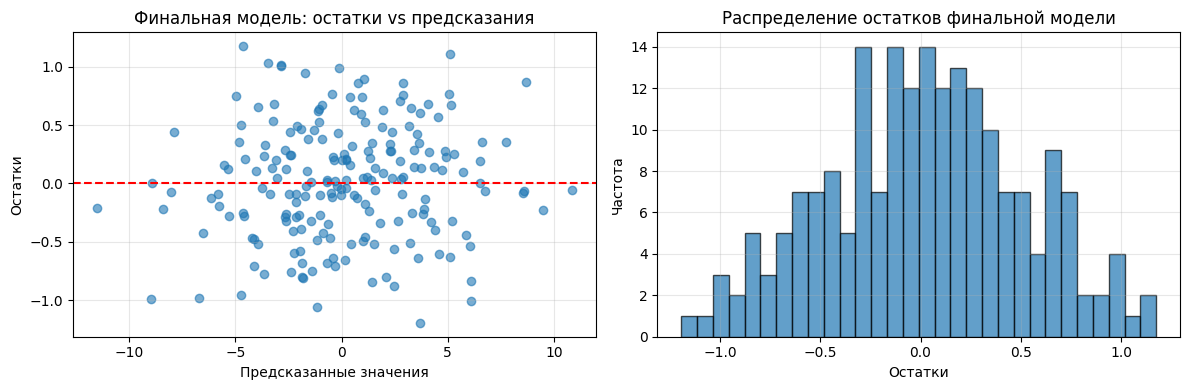

In [31]:
print("7.1 ФИНАЛЬНАЯ МОДЕЛЬ И ОЦЕНКА НА TEST")
#  Ridge как лучшая модель
final_model = Ridge(alpha=ridge_cv.best_params_['alpha'])
final_model.fit(X_train_scaled, y_train_clean)

# Честная оценка на test
y_pred_test = final_model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test_clean, y_pred_test)
test_mae = mean_absolute_error(y_test_clean, y_pred_test)
test_r2 = final_model.score(X_test_scaled, y_test_clean)

print(f"Финальная модель: Ridge (alpha={ridge_cv.best_params_['alpha']:.4f})")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Сравнение с другими моделями на test
models_comparison = {
    'OLS': omega_analytical,
    'Ridge': final_model.coef_,
    'Lasso': best_lasso.coef_,
    'ElasticNet': best_en.coef_
}

#  MSE для всех моделей на test
test_results = {}
for name, coef in models_comparison.items():
    if name == 'OLS':
        y_pred = X_test_scaled @ coef
    else:
        y_pred = final_model.predict(X_test_scaled) if name == 'Ridge' else \
                best_lasso.predict(X_test_scaled) if name == 'Lasso' else \
                best_en.predict(X_test_scaled)
    test_results[name] = mean_squared_error(y_test_clean, y_pred)

print("\nMSE НА TEST ДЛЯ РАЗНЫХ МОДЕЛЕЙ:")
for model, mse in test_results.items():
    print(f"{model}: {mse:.4f}")

# визуализация остатков
final_residuals = y_test_clean - y_pred_test

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, final_residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Финальная модель: остатки vs предсказания')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(final_residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков финальной модели')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**(i) Данные и предподготовка**  
Синтетические данные с 5 признаками, включая мультиколлинеарные (X4, X5 как линейные комбинации). Добавлены 7% выбросов в целевую переменную. Стандартизация применена для корректной работы регуляризации и сравнения коэффициентов.

**(ii) Лучшая модель**  
Ridge регрессия показала наилучший баланс между качеством и устойчивостью.


**(iii) Ключевые графики**  
 Основные insights получены из: матрицы корреляций (высокая мультиколлинеарность), путей решений Lasso (зануление коэффициентов), сравнения MSE/MAE на данных с выбросами (устойчивость методов), графика смещение-разброс (оптимальный alpha).

**(iv) Предотвращение утечек**  
 Разделение на train/val/test до любого анализа, стандартизация только на train данных, подбор гиперпараметров только на val, финальная оценка один раз на test.

**(v) Трудности**  
Lasso показал излишнюю агрессивность в отборе признаков на наших данных, обнуляя важные коэффициенты.

